In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

In [0]:
def nn_init(layer_dims):
    
    L = len(layer_dims) - 1
    
    param = {'L': L}
    
    for l in range(1, L + 1):
        param['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])
        param['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
    return param

In [0]:
def relu(Z):
    return Z * (Z > 0)


In [0]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [0]:
def nn_forward(X, param):
    
    L = param['L']
    
    A = X
    cache = {'A0': A }

    for l in range(1, L + 1):
        
        W = param['W' + str(l)]
        b = param['b' + str(l)]
        
        Z = W @ A + b

        A = relu(Z) if l != L else sigmoid(Z)
        
        cache['A' + str(l)] = A

    return A, cache


In [0]:
def loss(A, Y):
    N = A.shape[1]
    return np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / -N

In [0]:
def relu_backward(Z):
    return Z > 0
 
def last_layer_backward(A, Y):
    N = A.shape[1]
    return (A * (1-Y) - Y * (1-A)) / N
 
def nn_backward(Y, param, cache):

    L          = param['L']
    A          = cache['A' + str(L)]
    N          = A.shape[1]
    
    grad = {}
    
    for l in reversed(range(1, L + 1)):
        
        A_prev = cache['A' + str(l-1)]
        W      = param['W' + str(l)]
        
        dZ = dA * relu_backward(A) if l !=L else last_layer_backward(A, Y)
        
        grad['dW' + str(l)] = dZ @ A_prev.T
        grad['db' + str(l)] = dZ.sum(axis=1, keepdims=True)
        
        dA = W.T @ dZ
        
        A = A_prev
    
    return grad


In [0]:
def update_param(param, grad, learning_rate=0.01):
    
    for l in range(1, param['L'] + 1):
        param['W' + str(l)] -= grad['dW' + str(l)] * learning_rate
        param['b' + str(l)] -= grad['db' + str(l)] * learning_rate


In [0]:
def train(X, Y, param, epochs=50000, learning_rate=0.001,
          print_every=10000):
    
    costs = []
    
    for epoch in range(epochs + 1):
        
        A, cache = nn_forward(X, param)             #1
        grad = nn_backward(Y, param, cache)         #2
        update_param(param, grad, learning_rate)    #3
        
        if epoch % print_every == 0:
            cost = loss(A, Y)
            costs.append(cost)
            print('epoch {}, loss: {}'.format(epoch, cost))
    
    return costs


In [0]:
def predict(X, param):
    A, _ = nn_forward(X, param)
    return A > 0.5
    
def evaluate_classifier(X, Y_true, param):
    Y_pred = predict(X, param)
    return np.mean(Y_pred == Y_true)

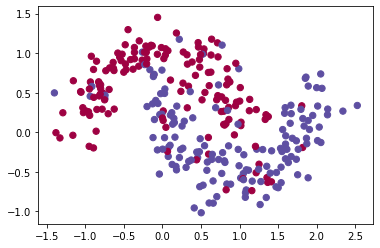

In [0]:
def load_dataset():

    n_samples = 300
    np.random.seed(0)
    
    X, Y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.2) 
    X = X.T
    
    flip    = np.random.choice(range(n_samples), 40)    #add in some outliers
    Y[flip] = 1 - Y[flip]
    
    return X, Y
    
X, Y = load_dataset()
    
plt.scatter(X[0], X[1], c=Y, s=40, cmap='Spectral')
plt.show()

In [0]:
def split_dataset(X, Y, ratio=0.8):

    N = X.shape[1]
    split = int(N * ratio)

    shuffle = np.random.permutation(N)

    X_train = X[:,shuffle[:split]]
    X_test  = X[:,shuffle[split:]]
    Y_train = Y[shuffle[:split]]
    Y_test  = Y[shuffle[split:]]
    
    return (X_train, Y_train), (X_test, Y_test)

(X_train, Y_train), (X_test, Y_test) = split_dataset(X, Y)

print('X_train shape: {}'.format(X_train.shape))
print('Y_train shape: {}'.format(Y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('Y_test shape: {}'.format(Y_test.shape))


X_train shape: (2, 240)
Y_train shape: (240,)
X_test shape: (2, 60)
Y_test shape: (60,)


In [0]:
d_in = X_train.shape[0]
d_out = 1
layer_dims = [d_in, 8, d_out]

param = nn_init(layer_dims)

costs = train(X_train, Y_train, param,
              epochs=500000, learning_rate=0.001, print_every=100000)

epoch 0, loss: 0.8943569024225951
epoch 100000, loss: 0.47308653964775604
epoch 200000, loss: 0.46855221922894785
epoch 300000, loss: 0.40372674060427743
epoch 400000, loss: 0.36625403094480086
epoch 500000, loss: 0.35062643425360634


In [0]:
def plot_costs(costs, plot_every=1000, learning_rate=.001):

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x{})'.format(plot_every))
    plt.title("learning rate = {}".format(learning_rate))
    plt.show()


def plot_decision_boundary(X, Y, param, contourgrad = False):

    cmap = 'Spectral'
    h = 0.01
    x_min, x_max = X[0,:].min() - 10*h, X[0,:].max() + 10*h
    y_min, y_max = X[1,:].min() - 10*h, X[1,:].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    mesh = (np.c_[xx.ravel(), yy.ravel()]).T
    Z = predict(mesh, param)
    Z = Z.T.reshape(xx.shape)

    plt.figure(figsize=(5,5))
    if contourgrad:
        A, _ = nn_forward(mesh, param)
        plt.contourf(xx, yy, A.T.reshape(xx.shape), cmap=cmap, alpha=.3)
    else:
        plt.contourf(xx, yy, Z, cmap=cmap, alpha=.3)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
    plt.scatter(X[0,:], X[1,:], c=Y.squeeze(), cmap=cmap)
    plt.show()


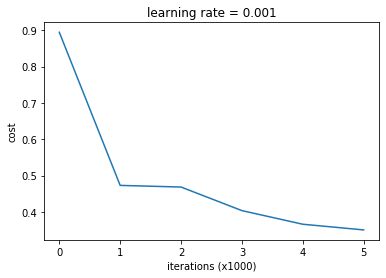

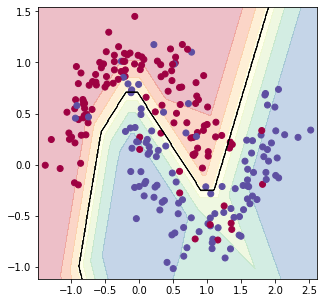

accuracy on train set: 0.8666666666666667
accuracy on test set: 0.8


In [0]:
plot_costs(costs)
plot_decision_boundary(X_train, Y_train, param, contourgrad = True)

accuracy = evaluate_classifier(X_train, Y_train, param)
print('accuracy on train set: {}'.format(accuracy))
accuracy = evaluate_classifier(X_test, Y_test, param)
print('accuracy on test set: {}'.format(accuracy))


In [0]:
def softmax(Z):
    A = np.exp(Z - np.max(Z, axis=0))
    return A / A.sum(axis=0)

In [0]:
def loss(A, Y):
    N = A.shape[1]
    return np.sum(np.log(A[Y, range(N)])) / -N


In [0]:
def last_layer_backward(A, Y):
    N = A.shape[1]
    dZ = np.copy(A) #copy to not modify original
    dZ[Y, range(N)] -= 1
    return dZ / N

In [0]:
def predict(X, param):
    A, _ = nn_forward(X, param)
    return np.argmax(A, axis=0)

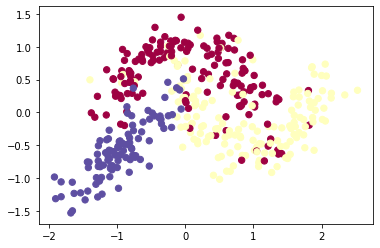

In [0]:
def load_dataset_multi():
    X, Y = load_dataset()
    Z = np.random.multivariate_normal( [-5, -3], [[5, 4], [4, 5]], size=100) / 5

    X = np.concatenate((X, Z.T), axis=1)
    Y = np.append(Y, (np.ones((1,100)) * 2).astype('int'))

    plt.scatter(X[0], X[1], c=Y, s=40, cmap='Spectral');
    plt.show()
    return X, Y

X, Y = load_dataset_multi()
(X_train, Y_train), (X_test, Y_test) = split_dataset(X, Y)


epoch 0, loss: 0.8492644177201928
epoch 10000, loss: 0.584044408860389
epoch 20000, loss: 0.5478712675155261
epoch 30000, loss: 0.5135834238863085
epoch 40000, loss: 0.500427787036695
epoch 50000, loss: 0.4898009397411907


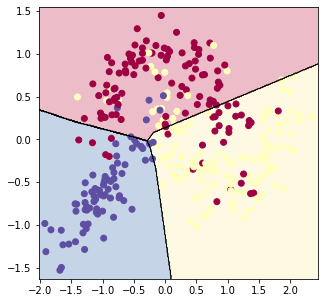

accuracy on train set: 0.8125
accuracy on test set: 0.75


In [0]:
d_in = X_train.shape[0]
d_out = Y_train.shape[0]
layer_dims = [d_in, 8, d_out]

param = nn_init(layer_dims)
train(X_train, Y_train, param, learning_rate=.001)

plot_decision_boundary(X_train, Y_train, param)

accuracy = evaluate_classifier(X_train, Y_train, param)
print('accuracy on train set: {}'.format(accuracy))
accuracy = evaluate_classifier(X_test, Y_test, param)
print('accuracy on test set: {}'.format(accuracy))
